# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2018-01-10/raw files/"
file_name = "DS_inv_20170110.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/DS/'
sum_file = "DS_inv_comp.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def df_SE(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SE])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, filenumber):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new - ((new.shift(1) + new.shift(-1))/2)))
    epsilon_2 = ((new_2 - ((new_2.shift(1) + new_2.shift(-1))/2)))
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    epsilon_comp = epsilon_comp[["Sample", "Filenumber","eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "eSn_124_118"]]
    epsilon_comp = epsilon_comp[(epsilon_comp["Filenumber"] >= -filenumber) & (epsilon_comp["Filenumber"] <= filenumber)]
    epsilon_comp["Filenumber"] = df["Filenumber"].ix[epsilon_comp.index]
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

[]

# Plot raw data and check measurement

In [199]:
baseline["Sample"].unique()

array(['blank sol', 'NIST + DS opt. 0.6-0.4', 'NIST + DS 0.25-0.75',
       'NIST + DS 0.30-0.70', 'NIST + DS 0.40-0.60', 'NIST + DS 0.50-0.50',
       'NIST + DS 0.70-0.30', 'NIST + DS 0.80-0.20', 'NIST + DS 0.85-0.15',
       'SPEX1 + DS opt. 0.6-0.4', 'NIST + DS 0.55-0.45', 'BHVO-2 DS 1_1',
       'BHVO-2 DS 2_1', 'AGV-2 DS 1_1', 'BCR-2 DS 1_1', 'GSP-2 DS 1_1',
       'SPEX1 + DS 0.55-0.45'], dtype=object)

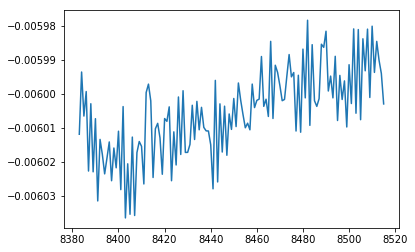

In [200]:
# Check Baselines
column = "118"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

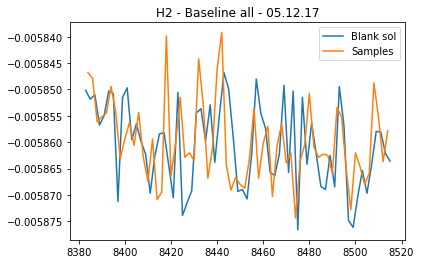

In [201]:
# Check blank vs samples
column = "123"


raw_data = hdf5_file['/raw_data/baselines']

def plotx(df):
    blank = df[df["Sample"] == "blank sol"]
    samples = df[df["Sample"] != "blank sol"]

    #baseline = baseline[baseline["Filenumber"] == 8979]
    plt.plot(blank["Filenumber"], blank[column], label="Blank sol")
    plt.plot(samples["Filenumber"], samples[column], label="Samples")
    plt.title("H2 - Baseline all - 05.12.17")
    plt.legend()
    plt.show()
    
plotx(raw_data)

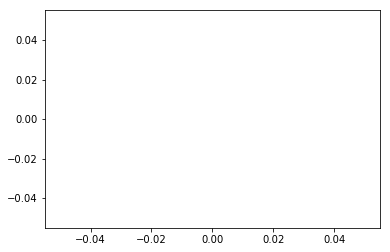

In [202]:
# Check Signals
column = "123"
sample = "NIST + DS 0.55-0.45"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

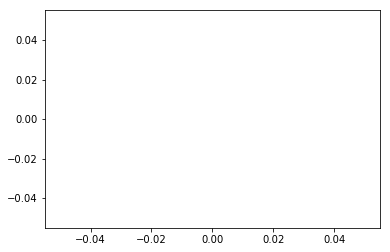

In [203]:
# Check Signals - mean
column = "123"
sample = "NIST + DS 0.55-0.45"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

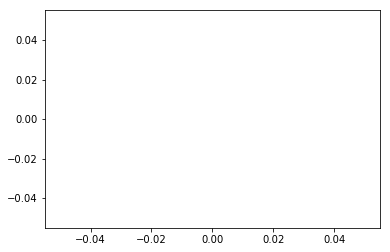

In [204]:
# Check raw ratios 
column = "124/117"
sample = "NIST + DS 0.55-0.45"

raw_ratios = hdf5_file['/evaluation/bgd_outlier_corr/df_raw_ratios']
raw_ratios_sub = raw_ratios[raw_ratios["Sample"] == sample]
plt.plot(raw_ratios_sub["Filenumber"], raw_ratios_sub[column])
plt.show()

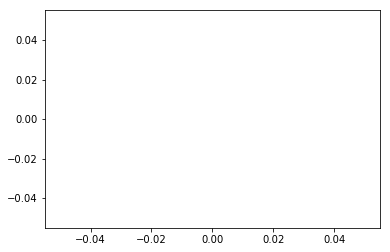

In [205]:
# Check background 
column = "124"
sample = "NIST + DS 0.55-0.45"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [206]:
# Create Dataframe for signals_bgd corr

signal_bgd_corr = signals[signals["Sample"] != "blank sol"].drop(["Sample", "Filenumber", "Cycle", "Num_of_Ana_Cyc"], axis = 1) - background.drop(["Sample", "Filenumber", "Cycle", "Num_of_Ana_Cyc"], axis = 1)
signal_bgd_corr["Sample"] = background["Sample"]
signal_bgd_corr["Filenumber"] = background["Filenumber"]
signal_bgd_corr["Cycle"] = background["Cycle"]
signal_bgd_corr["Num_of_Ana_Cyc"] = background["Num_of_Ana_Cyc"]
signal_bgd_corr["Te/Sn_nat"] = (signal_bgd_corr["126"]/18.8066)/(signal_bgd_corr["118"]/24.223)

# Outlier rejection

In [207]:
bgd_method = "bgd_outlier_corr"
interf_corr = "Te126_Xe129_corr"

In [208]:
df_all_bf_int = hdf5_file['/evaluation/'+bgd_method+'/'+interf_corr+'/df_DS_inv_bf_interf_corr']
df_all_int_corr = hdf5_file['/evaluation/'+bgd_method+'/'+interf_corr+'/df_amount_interf_corr']
df_all = hdf5_file['/evaluation/'+bgd_method+'/'+interf_corr+'/df_DS_inv_af_interf_corr']

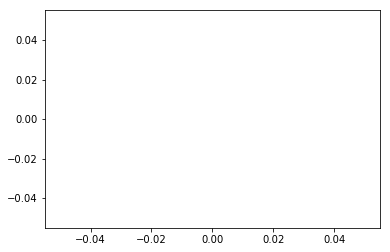

In [209]:
# Check ratios for bracketing standard
column = "Nr2:x"

df_all_sub = df_all[df_all["Sample"] == "NIST + DS 0.55-0.45"]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [210]:
# Outlier rejection

df_outlier_rej = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


In [211]:
# Outliers for selected column
column = 'eSn_118_117'
df_outlier[df_outlier[column].notnull()][column]

Filenumber  Date               
8402        2017-09-21 17:20:00   -1.297674
8422        2017-09-21 20:09:00   -0.704350
            2017-09-21 20:09:00   -1.660332
8430        2017-09-21 21:13:00   -2.248064
8432        2017-09-21 21:30:00   -0.845378
            2017-09-21 21:30:00    0.058601
            2017-09-21 21:30:00   -1.230947
8436        2017-09-21 22:02:00   -1.727672
8440        2017-09-21 22:34:00   -2.014662
8446        2017-09-21 23:22:00   -1.592963
            2017-09-21 23:22:00   -1.871608
            2017-09-21 23:22:00   -1.908563
8452        2017-09-22 00:11:00   -1.749171
8488        2017-09-22 05:01:00   -1.643176
8504        2017-09-22 07:10:00   -1.506350
            2017-09-22 07:10:00   -1.567133
            2017-09-22 07:10:00   -0.825008
            2017-09-22 07:10:00   -1.576022
8510        2017-09-22 07:58:00   -1.608906
Name: eSn_118_117, dtype: float64

In [212]:
# create Dataframe for only fractionation factores

df_frac = df_outlier_rej.loc[:, df_outlier_rej.columns.to_series().str.contains('frac').tolist()]
df_frac["Sample"] = df_outlier_rej["Sample"]
df_frac["Filenumber"] = df_outlier_rej["Filenumber"]
df_frac["Cycle"] = df_outlier_rej["Cycle"]

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

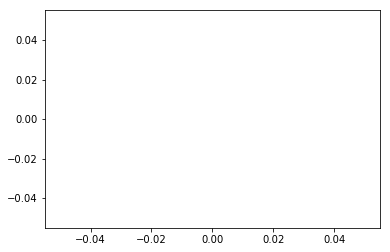

In [213]:
# Check sample measurements
column = "Nr2:x"

df_outlier_rej_sub = df_outlier_rej[df_outlier_rej["Sample"] == "NIST + DS 0.55-0.45"]
plt.plot(df_outlier_rej_sub["Filenumber"], df_outlier_rej_sub[column])
plt.show()

In [214]:
df_outlier_rej[df_outlier_rej["Sample"] == "NIST + DS 0.55-0.45"][column].std()

nan

In [215]:
# calculate Mean of Dataframes
data_mean = df_mean(df_outlier_rej)
data_mean_sd = df_SD(df_outlier_rej)
signals_bgd_mean_sd = df_SD(signal_bgd_corr)
inter_corr_mean_sd = df_SD(df_all_int_corr)

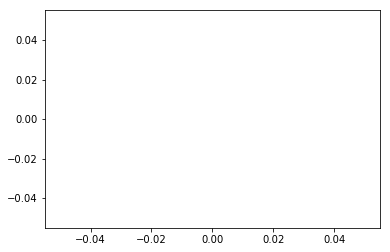

In [216]:
# Check sample measurements - mean
column = "Nr2:x"

df_mean_sub = data_mean[data_mean["Sample"] == "NIST + DS opt. 0.6-0.4"]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [217]:
df_outlier_mean_sub = mad_outlier_mean(df_mean_sub)

In [218]:
# create summary per sample
data_mean_sum = data_mean.groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_sum = data_mean_sum[["Nr2:x", "Nr2:y", "Nr2:z", "eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "eSn_124_118", "Q", "fspike"]]

In [219]:
data_mean_sum

Nr2:x                     Nr2:y                  \
                             mean       SD2 count      mean       SD2 count   
Sample                                                                        
NIST + DS 0.4-0.6        3.157379  0.000033     5  0.603550  0.000031     5   
NIST + DS 0.5-0.5        3.157381  0.000027     5  0.603552  0.000025     5   
NIST + DS 0.7-0.3        3.157394  0.000031     4  0.603563  0.000029     4   
NIST + DS 0.8-0.2        3.157426  0.000040     4  0.603594  0.000038     4   
NIST + DS opt. 0.6-0.4   3.157384  0.000027    44  0.603555  0.000025    44   
SPEX1 + DS opt. 0.6-0.4  3.157629  0.000045     4  0.603785  0.000042     4   

                            Nr2:z                 eSn_118_117  ...   \
                             mean       SD2 count        mean  ...    
Sample                                                         ...    
NIST + DS 0.4-0.6        0.754044  0.000053     5   -1.257380  ...    
NIST + DS 0.5-0.5        0.754048  0.000044     5   -1.249876  ...    
NIST + DS 0.7-0.3        0.754068  0.000050     4   -1.210633  ...    
NIST + DS 0.8-0.2        0.754121  0.000066     4   -1.107273  ...    
NIST + DS opt. 0.6-0.4   0.754053  0.000044    44   -1.239819  ...    
SPEX1 + DS opt. 0.6-0.4  0.754453  0.000073     4   -0.464926  ...    

                        eSn_122_118 eSn_124_118                         Q  \
                              count        mean       SD2 count      mean   
Sample                                                                      
NIST + DS 0.4-0.6                 5   -7.339356  0.601445     5  0.693384   
NIST + DS 0.5-0.5                 5   -7.295545  0.493453     5  1.022285   
NIST + DS 0.7-0.3                 4   -7.066554  0.566438     4  2.406998   
NIST + DS 0.8-0.2                 4   -6.463350  0.747906     4  4.147171   
NIST + DS opt. 0.6-0.4           44   -7.236867  0.494144    44  1.544961   
SPEX1 + DS opt. 0.6-0.4           4   -2.714278  0.827976     4  1.319337   

                                           fspike                  
                              SD2 count      mean       SD2 count  
Sample                                                             
NIST + DS 0.4-0.6        0.000062     5  0.590534  0.000021     5  
NIST + DS 0.5-0.5        0.000073     5  0.494490  0.000018     5  
NIST + DS 0.7-0.3        0.000114     4  0.293513  0.000010     4  
NIST + DS 0.8-0.2        0.000207     4  0.194281  0.000008     4  
NIST + DS opt. 0.6-0.4   0.000056    44  0.392933  0.000009    44  
SPEX1 + DS opt. 0.6-0.4  0.000085     4  0.431158  0.000016     4  

[6 rows x 30 columns]

In [244]:
# Calculate SSB 
epsilon_1 = SSB(data_mean, "NIST + DS opt. 0.6-0.4 ", 1)
#epsilon_2 = SSB(data_mean, "NIST + DS 0.55-0.45", 1)


/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:162: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [245]:
epsilon_all = epsilon_1
#epsilon_all = epsilon_1.append(epsilon_2)

In [246]:
epsilon_all

,Sample,Filenumber,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118
Date,,,,,,,
2017-09-21 15:11:00,NIST + DS 0.4-0.6,8386,-0.036806,-0.181152,-0.251544,-0.144378,-0.214786
2017-09-21 15:27:00,NIST + DS opt. 0.6-0.4,8388,-0.039354,-0.193665,-0.268899,-0.154357,-0.229614
2017-09-21 15:43:00,NIST + DS 0.5-0.5,8390,-0.044846,-0.220700,-0.306444,-0.175903,-0.261671
2017-09-21 16:00:00,NIST + DS opt. 0.6-0.4,8392,0.062991,0.310010,0.430457,0.247084,0.367562
2017-09-21 16:16:00,NIST + DS 0.7-0.3,8394,0.005766,0.028421,0.039493,0.022643,0.033709
2017-09-21 16:32:00,NIST + DS opt. 0.6-0.4,8396,-0.007450,-0.036677,-0.050935,-0.029230,-0.043489
2017-09-21 16:48:00,NIST + DS 0.8-0.2,8398,0.125788,0.619104,0.859671,0.493428,0.734050
2017-09-21 17:04:00,NIST + DS opt. 0.6-0.4,8400,-0.035373,-0.174081,-0.241712,-0.138746,-0.206397
2017-09-21 17:20:00,SPEX1 + DS opt. 0.6-0.4,8402,0.765206,3.766513,5.230288,3.001864,4.465910


In [247]:
def data_summary(data, signal_bgd_corr, inter_corr, epsilon_SBB):
    
    data_mean_sd_sub = data[["Sample", "Filenumber", "Nr2:x", "Nr2:y", "Nr2:z", "Mr2.5:x", "Mr2.5:y", "Mr2.5:z","eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "Q"]]
    data_mean_sd_sub["117", "mean"] = signal_bgd_corr["117", "mean"]
    data_mean_sd_sub["118", "mean"] = signal_bgd_corr["118", "mean"]
    data_mean_sd_sub["126", "mean"] = signal_bgd_corr["126", "mean"]
    data_mean_sd_sub["Te/Sn_nat", "mean"] = signal_bgd_corr["Te/Sn_nat", "mean"]
    data_mean_sd_sub["interf_corr_on_124_117", "mean"] = inter_corr["124/117", "mean"]
    
    data_mean_sd_sub["e118_117", "SSB"] = epsilon_SBB["eSn_118_117"]
    data_mean_sd_sub["e122_117", "SSB"] = epsilon_SBB["eSn_122_117"]
    data_mean_sd_sub["e124_117", "SSB"] = epsilon_SBB["eSn_124_117"]
    data_mean_sd_sub["e122_118", "SSB"] = epsilon_SBB["eSn_122_118"]
    
    return data_mean_sd_sub

In [248]:
data_sum = data_summary(data_mean_sd, signals_bgd_mean_sd, inter_corr_mean_sd, epsilon_all)


/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [249]:
data_sum

Sample Filenumber     Nr2:x            \
                                                             mean       SD2   
Date                                                                          
2017-09-21 14:55:00  NIST + DS opt. 0.6-0.4        8384  3.157369  0.000129   
2017-09-21 15:11:00       NIST + DS 0.4-0.6        8386  3.157356  0.000120   
2017-09-21 15:27:00  NIST + DS opt. 0.6-0.4        8388  3.157367  0.000157   
2017-09-21 15:43:00        NIST + DS 0.5-0.5       8390  3.157364  0.000159   
2017-09-21 16:00:00  NIST + DS opt. 0.6-0.4        8392  3.157389  0.000131   
2017-09-21 16:16:00        NIST + DS 0.7-0.3       8394  3.157383  0.000187   
2017-09-21 16:32:00  NIST + DS opt. 0.6-0.4        8396  3.157372  0.000124   
2017-09-21 16:48:00        NIST + DS 0.8-0.2       8398  3.157406  0.000171   
2017-09-21 17:04:00  NIST + DS opt. 0.6-0.4        8400  3.157360  0.000147   
2017-09-21 17:20:00  SPEX1 + DS opt. 0.6-0.4       8402  3.157606  0.000129   
2017-09-21 17:37:00  NIST + DS opt. 0.6-0.4        8404  3.157370  0.000151   
2017-09-21 17:53:00  NIST + DS opt. 0.6-0.4        8406  3.157371  0.000170   
2017-09-21 18:10:00  NIST + DS opt. 0.6-0.4        8408  3.157372  0.000095   
2017-09-21 18:26:00  NIST + DS opt. 0.6-0.4        8410  3.157377  0.000140   
2017-09-21 18:48:00  NIST + DS opt. 0.6-0.4        8412  3.157365  0.000150   
2017-09-21 19:04:00  NIST + DS opt. 0.6-0.4        8414  3.157384  0.000106   
2017-09-21 19:21:00       NIST + DS 0.4-0.6        8416  3.157376  0.000148   
2017-09-21 19:37:00  NIST + DS opt. 0.6-0.4        8418  3.157368  0.000135   
2017-09-21 19:53:00        NIST + DS 0.5-0.5       8420  3.157370  0.000158   
2017-09-21 20:09:00  NIST + DS opt. 0.6-0.4        8422  3.157388  0.000095   
2017-09-21 20:25:00        NIST + DS 0.7-0.3       8424  3.157384  0.000125   
2017-09-21 20:41:00  NIST + DS opt. 0.6-0.4        8426  3.157377  0.000083   
2017-09-21 20:57:00        NIST + DS 0.8-0.2       8428  3.157445  0.000175   
2017-09-21 21:13:00  NIST + DS opt. 0.6-0.4        8430  3.157405  0.000133   
2017-09-21 21:30:00  SPEX1 + DS opt. 0.6-0.4       8432  3.157633  0.000076   
2017-09-21 21:46:00  NIST + DS opt. 0.6-0.4        8434  3.157396  0.000124   
2017-09-21 22:02:00  NIST + DS opt. 0.6-0.4        8436  3.157397  0.000108   
2017-09-21 22:18:00  NIST + DS opt. 0.6-0.4        8438  3.157381  0.000149   
2017-09-21 22:34:00  NIST + DS opt. 0.6-0.4        8440  3.157408  0.000114   
2017-09-21 22:50:00  NIST + DS opt. 0.6-0.4        8442  3.157381  0.000141   
...                                      ...        ...       ...       ...   
2017-09-22 00:43:00        NIST + DS 0.7-0.3       8456  3.157392  0.000141   
2017-09-22 00:59:00  NIST + DS opt. 0.6-0.4        8458  3.157388  0.000146   
2017-09-22 01:15:00        NIST + DS 0.8-0.2       8460  3.157412  0.000131   
2017-09-22 01:31:00  NIST + DS opt. 0.6-0.4        8462  3.157381  0.000155   
2017-09-22 01:47:00  SPEX1 + DS opt. 0.6-0.4       8464  3.157618  0.000110   
2017-09-22 02:04:00  NIST + DS opt. 0.6-0.4        8466  3.157395  0.000151   
2017-09-22 02:20:00  NIST + DS opt. 0.6-0.4        8468  3.157368  0.000166   
2017-09-22 02:36:00  NIST + DS opt. 0.6-0.4        8470  3.157384  0.000145   
2017-09-22 02:52:00  NIST + DS opt. 0.6-0.4        8472  3.157375  0.000118   
2017-09-22 03:08:00  NIST + DS opt. 0.6-0.4        8474  3.157379  0.000110   
2017-09-22 03:24:00  NIST + DS opt. 0.6-0.4        8476  3.157373  0.000191   
2017-09-22 03:40:00  NIST + DS opt. 0.6-0.4        8478  3.157385  0.000148   
2017-09-22 03:56:00       NIST + DS 0.4-0.6        8480  3.157395  0.000122   
2017-09-22 04:13:00  NIST + DS opt. 0.6-0.4        8482  3.157377  0.000148   
2017-09-22 04:29:00        NIST + DS 0.5-0.5       8484  3.157390  0.000128   
2017-09-22 04:45:00  NIST + DS opt. 0.6-0.4        8486  3.157386  0.000123   
2017-09-22 05:01:00        NIST + DS 0.7-0.3       8488  3.157416  0.000097   
2017-09-2

In [255]:
data_sum_sub = data_sum[(data_sum["Sample"]== "NIST + DS opt. 0.6-0.4 ")]

In [256]:
data_sum_sub

Sample Filenumber     Nr2:x            \
                                                             mean       SD2   
Date                                                                          
2017-09-21 14:55:00  NIST + DS opt. 0.6-0.4        8384  3.157369  0.000129   
2017-09-21 15:27:00  NIST + DS opt. 0.6-0.4        8388  3.157367  0.000157   
2017-09-21 16:00:00  NIST + DS opt. 0.6-0.4        8392  3.157389  0.000131   
2017-09-21 16:32:00  NIST + DS opt. 0.6-0.4        8396  3.157372  0.000124   
2017-09-21 17:04:00  NIST + DS opt. 0.6-0.4        8400  3.157360  0.000147   
2017-09-21 17:37:00  NIST + DS opt. 0.6-0.4        8404  3.157370  0.000151   
2017-09-21 17:53:00  NIST + DS opt. 0.6-0.4        8406  3.157371  0.000170   
2017-09-21 18:10:00  NIST + DS opt. 0.6-0.4        8408  3.157372  0.000095   
2017-09-21 18:26:00  NIST + DS opt. 0.6-0.4        8410  3.157377  0.000140   
2017-09-21 18:48:00  NIST + DS opt. 0.6-0.4        8412  3.157365  0.000150   
2017-09-21 19:04:00  NIST + DS opt. 0.6-0.4        8414  3.157384  0.000106   
2017-09-21 19:37:00  NIST + DS opt. 0.6-0.4        8418  3.157368  0.000135   
2017-09-21 20:09:00  NIST + DS opt. 0.6-0.4        8422  3.157388  0.000095   
2017-09-21 20:41:00  NIST + DS opt. 0.6-0.4        8426  3.157377  0.000083   
2017-09-21 21:13:00  NIST + DS opt. 0.6-0.4        8430  3.157405  0.000133   
2017-09-21 21:46:00  NIST + DS opt. 0.6-0.4        8434  3.157396  0.000124   
2017-09-21 22:02:00  NIST + DS opt. 0.6-0.4        8436  3.157397  0.000108   
2017-09-21 22:18:00  NIST + DS opt. 0.6-0.4        8438  3.157381  0.000149   
2017-09-21 22:34:00  NIST + DS opt. 0.6-0.4        8440  3.157408  0.000114   
2017-09-21 22:50:00  NIST + DS opt. 0.6-0.4        8442  3.157381  0.000141   
2017-09-21 23:06:00  NIST + DS opt. 0.6-0.4        8444  3.157372  0.000107   
2017-09-21 23:22:00  NIST + DS opt. 0.6-0.4        8446  3.157404  0.000080   
2017-09-21 23:55:00  NIST + DS opt. 0.6-0.4        8450  3.157377  0.000099   
2017-09-22 00:27:00  NIST + DS opt. 0.6-0.4        8454  3.157402  0.000084   
2017-09-22 00:59:00  NIST + DS opt. 0.6-0.4        8458  3.157388  0.000146   
2017-09-22 01:31:00  NIST + DS opt. 0.6-0.4        8462  3.157381  0.000155   
2017-09-22 02:04:00  NIST + DS opt. 0.6-0.4        8466  3.157395  0.000151   
2017-09-22 02:20:00  NIST + DS opt. 0.6-0.4        8468  3.157368  0.000166   
2017-09-22 02:36:00  NIST + DS opt. 0.6-0.4        8470  3.157384  0.000145   
2017-09-22 02:52:00  NIST + DS opt. 0.6-0.4        8472  3.157375  0.000118   
2017-09-22 03:08:00  NIST + DS opt. 0.6-0.4        8474  3.157379  0.000110   
2017-09-22 03:24:00  NIST + DS opt. 0.6-0.4        8476  3.157373  0.000191   
2017-09-22 03:40:00  NIST + DS opt. 0.6-0.4        8478  3.157385  0.000148   
2017-09-22 04:13:00  NIST + DS opt. 0.6-0.4        8482  3.157377  0.000148   
2017-09-22 04:45:00  NIST + DS opt. 0.6-0.4        8486  3.157386  0.000123   
2017-09-22 05:17:00  NIST + DS opt. 0.6-0.4        8490  3.157391  0.000180   
2017-09-22 05:49:00  NIST + DS opt. 0.6-0.4        8494  3.157399  0.000147   
2017-09-22 06:22:00  NIST + DS opt. 0.6-0.4        8498  3.157395  0.000133   
2017-09-22 06:38:00  NIST + DS opt. 0.6-0.4        8500  3.157378  0.000161   
2017-09-22 06:54:00  NIST + DS opt. 0.6-0.4        8502  3.157397  0.000145   
2017-09-22 07:10:00  NIST + DS opt. 0.6-0.4        8504  3.157416  0.000061   
2017-09-22 07:26:00  NIST + DS opt. 0.6-0.4        8506  3.157389  0.000107   
2017-09-22 07:42:00  NIST + DS opt. 0.6-0.4        8508  3.157403  0.000136   
2017-09-22 08:14:00  NIST + DS opt. 0.6-0.4        8512  3.157400  0.000139   

                        Nr2:y               Nr2:z             Mr2.5:x  \
                         mean       SD2      mean       SD2      mean   
Date                                                                    
2017-09-21 14:55:00  0.603540  0.000122  0.754028  0.000211  0.603106   
2017-09-21 15:27:00  0.603538  0

In [257]:
epsilon_sum_1 = np.round(epsilon_1.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
#epsilon_sum_2 = np.round(epsilon_2.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
#epsilon_sum_all = epsilon_sum_1.append(epsilon_sum_2)
epsilon_sum_all = epsilon_sum_1
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)

In [258]:
epsilon_sum_all

eSn_118_117              eSn_122_117               \
                               mean    SD2 count        mean    SD2 count   
Sample                                                                      
NIST + DS 0.4-0.6            -0.014  0.076     5      -0.071  0.375     5   
NIST + DS 0.5-0.5            -0.008  0.067     4      -0.041  0.330     4   
NIST + DS 0.7-0.3             0.021  0.087     4       0.105  0.429     4   
NIST + DS 0.8-0.2             0.133  0.072     4       0.654  0.353     4   
NIST + DS opt. 0.6-0.4        0.000  0.095    42       0.000  0.467    42   
SPEX1 + DS opt. 0.6-0.4       0.765  0.090     4       3.766  0.444     4   

                        eSn_124_117              eSn_122_118               \
                               mean    SD2 count        mean    SD2 count   
Sample                                                                      
NIST + DS 0.4-0.6            -0.099  0.521     5      -0.057  0.299     5   
NIST + DS 0.5-0.5            -0.057  0.459     4      -0.033  0.263     4   
NIST + DS 0.7-0.3             0.146  0.595     4       0.084  0.342     4   
NIST + DS 0.8-0.2             0.908  0.490     4       0.521  0.281     4   
NIST + DS opt. 0.6-0.4        0.000  0.649    42       0.000  0.372    42   
SPEX1 + DS opt. 0.6-0.4       5.229  0.616     4       3.001  0.354     4   

                        eSn_124_118               
                               mean    SD2 count  
Sample                                            
NIST + DS 0.4-0.6            -0.085  0.445     5  
NIST + DS 0.5-0.5            -0.049  0.392     4  
NIST + DS 0.7-0.3             0.124  0.508     4  
NIST + DS 0.8-0.2             0.775  0.418     4  
NIST + DS opt. 0.6-0.4        0.000  0.554    42  
SPEX1 + DS opt. 0.6-0.4       4.465  0.526     4

In [42]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/' + interf_corr +'/data_outlier_corr_all', df_outlier_rej)
#hdf5_sum_file.append('/data_final/'+bgd_method + '/' + interf_corr +'/data_mean_sd', data_mean_sd)
#hdf5_sum_file.append('/data_final/'+bgd_method + '/' + interf_corr +'/data_epsilon', epsilon_all)



In [43]:
hdf5_sum_file['/data_final/bgd_outlier_corr/Te126_Xe129_corr/data_outlier_corr_all']

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,...,Nr2:z,frac_nat_x2,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118,fsam,fspike,Q
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,1,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753772,-0.020984,-1.784801,-8.785304,-12.199609,-7.001753,-10.416667,0.508988,0.491012,1.036608
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,2,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753927,-0.017435,-1.482997,-7.300172,-10.137590,-5.818037,-8.655876,0.509010,0.490990,1.036700
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,3,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753866,-0.018825,-1.601145,-7.881581,-10.944856,-6.281442,-9.345208,0.508991,0.491009,1.036622
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,4,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753988,-0.016052,-1.365366,-6.721276,-9.333794,-5.356641,-7.969517,0.508977,0.491023,1.036566
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,5,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.754124,-0.012954,-1.101810,-5.424151,-7.532675,-4.322817,-6.431574,0.508966,0.491034,1.036520
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,6,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753630,-0.024224,-2.060350,-10.141088,-14.081929,-8.082403,-12.024057,0.509004,0.490996,1.036676
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,7,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753978,-0.016283,-1.384955,-6.817680,-9.467653,-5.433478,-8.083818,0.508976,0.491024,1.036560
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,8,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753891,-0.018271,-1.554100,-7.650071,-10.623415,-6.096919,-9.070725,0.508984,0.491016,1.036594
2017-12-05 18:34:00,NIST + DS 0.5-0.5,1,9,8809,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,...,0.753901,-0.018033,-1.533838,-7.550363,-10.484973,-6.017448,-8.952509,0.508986,0.491014,1.036602


In [26]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

# Raw data to xls file

In [45]:
signals_raw = hdf5_file['/raw_data/signals_raw']
raw_ratios_no_bgd = hdf5_file['/evaluation/no_bgd_corr/df_raw_ratios']

In [46]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
raw_ratios_no_bgd.to_excel(writer_raw, index=True, sheet_name='raw_ratios_no_bgd_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')
raw_ratios.to_excel(writer_raw, index=True, sheet_name='raw_ratios_bgd_corr')

writer_raw.save()

In [259]:
writer_orig = pd.ExcelWriter(path+'bgd_corr_Te126_Xe129_corr.xlsx', engine='xlsxwriter')


In [260]:
df_all_bf_int.to_excel(writer_orig, index=True, sheet_name='DS_inv_bf_interf_corr_all')
df_all_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='DS_inv_af_interf_corr_all_used')
df_outlier_rej.to_excel(writer_orig, index=True, sheet_name='data_outlier_corr_all')
df_frac.to_excel(writer_orig, index=True, sheet_name='data_frac_all')
df_outlier.to_excel(writer_orig, index=True, sheet_name='data_outliers_all')
data_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_sd')
data_sum_sub.to_excel(writer_orig, index=True, sheet_name='data_mean_sd_only_stds')
data_mean_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_summary')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='data_SBB_summary')

In [261]:
writer_orig.save()

In [7]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')